# Исследование продаж компьютерных игр 

В нашем распоряжении данные по продажам компьютерных игр в Европе, Северной Америке и Японии до 2016 года. Нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании на будущий год.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
plt.rc('lines', linewidth=1)
plt.rcParams.update({'font.size': 8})

In [3]:
data = pd.read_csv('datasets/games.csv')

In [4]:
data.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


# Подготовка данных

In [6]:
data.columns = data.columns.str.lower() #приведем названия к нижнему регистру

Сменим тип данных. Столбец `'year_of_release'` — **`int`**, `'user_score'` — **`float`**, `'rating'` — **`float`**, предварительно заменив возрастные категории на числа.

In [7]:
#Перед преобразованием year в int нужно удалить пропуски, поскольку восстановить их не выйдет
data.dropna(subset=['year_of_release'], inplace=True)
data['year_of_release'] = data['year_of_release'].astype('int')

In [8]:
data['user_score'].value_counts()

tbd    2376
7.8     322
8       285
8.2     276
8.3     252
       ... 
2.3       2
1.3       2
0.5       2
0         1
9.7       1
Name: user_score, Length: 96, dtype: int64

Пока не определенные оценки встречаются чаще всего, удалять их нельзя. Но нам нужны остальные числовые данные. Заменим **'tbd'** на NaN и преобразуем столбец в тип `float`.

In [9]:
data['user_score'] = data['user_score'].replace('tbd', float('nan'))

In [10]:
#Если вызвать data.info(), увидим, что число ненулевых строк снизилось на 2к
#Теперь сменим тип данных
data['user_score'] = data['user_score'].astype('float')

In [11]:
#Заменим рейтинги в rating
data['rating'].value_counts()

E       3921
T       2905
M       1536
E10+    1393
EC         8
K-A        3
AO         1
RP         1
Name: rating, dtype: int64

In [12]:
data['rating'].isna().sum()

6678

Непопулярный рейтинг удалим, а остальные преобразуем по следующему правилу: `E (Everyone)` — 0, `T (Teen)` — 13, `M (Mature)` — 17, `E10+ (Everyone 10 and older)` — 10. Пропуски заполним строкой `'NA'`.

In [13]:
data = data[~data['rating'].isin(['EC', 'K-A', 'AO', 'RP'])] #уберем строки с 'EC', 'K-A', 'AO', 'RP'

In [14]:
def rating_edit(row):
    if row == 'E':
        return 0
    elif row == 'T':
        return 13
    elif row == 'M':
        return 17
    elif row == 'E10+':
        return 10
    return 'NA'

In [15]:
data['rating'] = data.loc[:,'rating'].apply(rating_edit)

Снова посмотрим на сводную информацию по преобразованному датафрейму.

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16433 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16431 non-null  object 
 1   platform         16433 non-null  object 
 2   year_of_release  16433 non-null  int32  
 3   genre            16431 non-null  object 
 4   na_sales         16433 non-null  float64
 5   eu_sales         16433 non-null  float64
 6   jp_sales         16433 non-null  float64
 7   other_sales      16433 non-null  float64
 8   critic_score     7980 non-null   float64
 9   user_score       7457 non-null   float64
 10  rating           16433 non-null  object 
dtypes: float64(6), int32(1), object(4)
memory usage: 1.4+ MB


Осталось удалить 2 пропуска в столбце `'name'`. Также мы видим >50% пропусков в столбцах с оценками. Это нормально, далеко не все ставят свою оценку, также 2000 оценок из `'critic_score'` только будут определены. Но если удалим их, потеряем все 50% строк датафрейма, поэтому целесообразно оставить все как есть.

In [17]:
data.dropna(subset=['name'], inplace=True)
data.reset_index(drop=True, inplace=True)

**Подсчет суммарных продаж по регионам:**

In [18]:
data['sales_all'] = data[['na_sales','eu_sales','jp_sales', 'other_sales']].sum(axis = 1)

In [19]:
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales_all
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,0,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NA,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,0,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,0,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NA,31.38


# Исследовательский анализ данных

Нужно выявить определяющие успешность игры закономерности, чтобы определить потенциально популярный продукт и спланировать рекламные кампании. Посмотрим на динамику выпуска новых игр, продажи по платформам. Попробуем определить прибыльные платформы и выясним, как отзывы влияют на продажи.

## Количество выпущенных игр в разные годы

In [20]:
sns.set(font_scale=0.85)

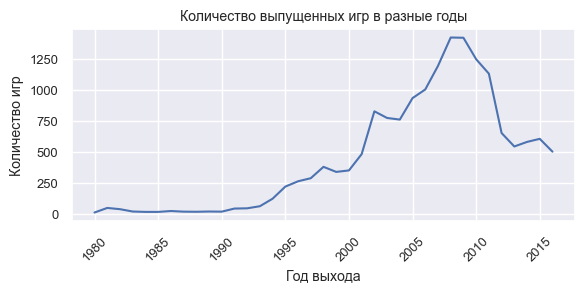

In [21]:
(data.pivot_table(index='year_of_release', values='name', aggfunc='count')
     .plot.line(rot=45, 
                xlabel='Год выхода', 
                ylabel='Количество игр',
                title='Количество выпущенных игр в разные годы',
                legend=False,
                grid=True,
                figsize=(6.5,2.5))
)
plt.show()

Мы видим, что наибольшее количество игр стало выпускаться под конец нулевых, а далее их объем сошел на убыль, резко оборвавшись в 2011 и сохранившись примерно на том же уровне. Возможно, это связано с разработкой требовательных к ресурсам игр с более продвинутой графикой. Также игры становились насыщеннее с точки зрения сценария и продолжительности, что тоже влияет на выпускаемое их количество в год. При этом сохраняется общая тенденция рынка — если потребитель заинтересован, допустим, в крупных играх, то значительная часть рынка будет удовлетворять этот запрос, разрабатывая их несколько лет.

Нам предстоит планировать рекламную кампанию на 2017 год, поэтому данные о старых играх в дальнейшем не понадобятся.

## Количество выпущенных игр по платформам

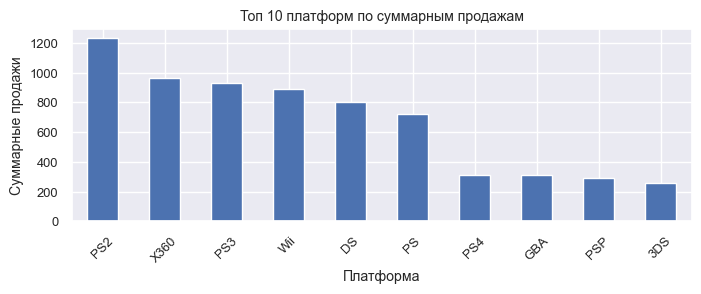

In [22]:
(data.pivot_table(index='platform', values='sales_all', aggfunc='sum').sort_values(by='sales_all', ascending=False).head(10)
     .plot.bar(rot=45, 
               xlabel='Платформа', 
               ylabel='Суммарные продажи', 
               title='Топ 10 платформ по суммарным продажам',
               legend=False,
               figsize=(8, 2.5))
)
plt.show()

## Отбор платформ с наибольшими продажами

In [23]:
#Сохраним индексы предыдущей таблицы
most_sales_platform = data.pivot_table(index='platform', values='sales_all', aggfunc='sum') \
                          .sort_values(by='sales_all', ascending=False).head(10).index

In [24]:
most_sales_platform

Index(['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS', 'PS4', 'GBA', 'PSP', '3DS'], dtype='object', name='platform')

**Посмотрим, как менялись продажи по популярным платформам. Чтобы графики были более информативными, посторим два периода: с 1995 по 2005 и с 2005 по 2016.**

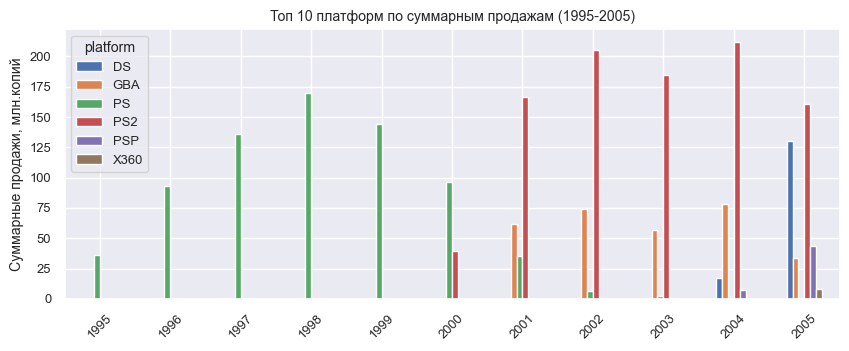

In [25]:
(data.query('(platform in @most_sales_platform) & (2005 >= year_of_release >= 1995)')
     .pivot_table(index='year_of_release', columns='platform', values='sales_all', aggfunc='sum')
     .plot.bar(rot=45, 
               xlabel='', 
               ylabel='Суммарные продажи, млн.копий', 
               title='Топ 10 платформ по суммарным продажам (1995-2005)',
               legend=True,
               figsize=(10, 3.5))
)
plt.show()

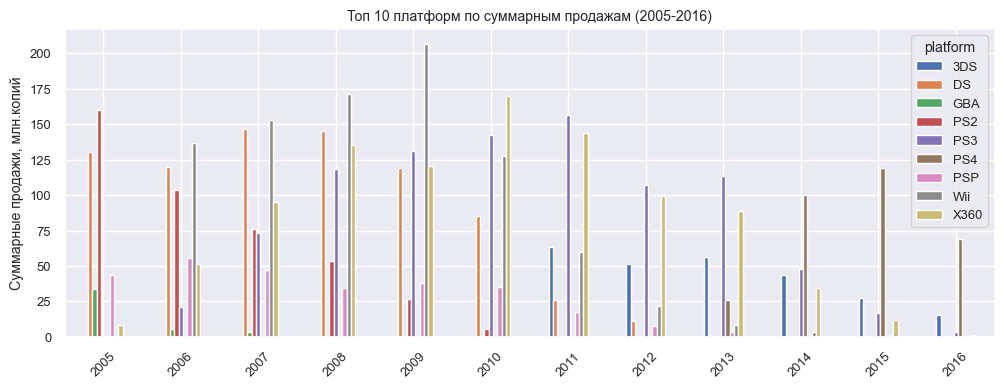

In [26]:
(data.query('(platform in @most_sales_platform) & (year_of_release >= 2005)')
     .pivot_table(index='year_of_release', columns='platform', values='sales_all', aggfunc='sum')
     .plot.bar(rot=45, 
               xlabel='', 
               ylabel='Суммарные продажи, млн.копий', 
               title='Топ 10 платформ по суммарным продажам (2005-2016)',
               legend=True,
               figsize=(12,4))
)
plt.show()

Наиболее популярные платформы меняются периодами, PS2 появилась в 2002 и к 2008 ее актуальность значительно затухла, то же самое с PS1 (1995-2001) и с Wii (2006-2012). Популярность некоторых продлилась 8 лет (X360 и PS3). Можно предположить, что период актуальности составляет в среднем 6-8 лет.

**Теперь построим график по всем платформам, поскольку в most_sales_platform могли не попасать консоли, актуальные на 2016 год.**

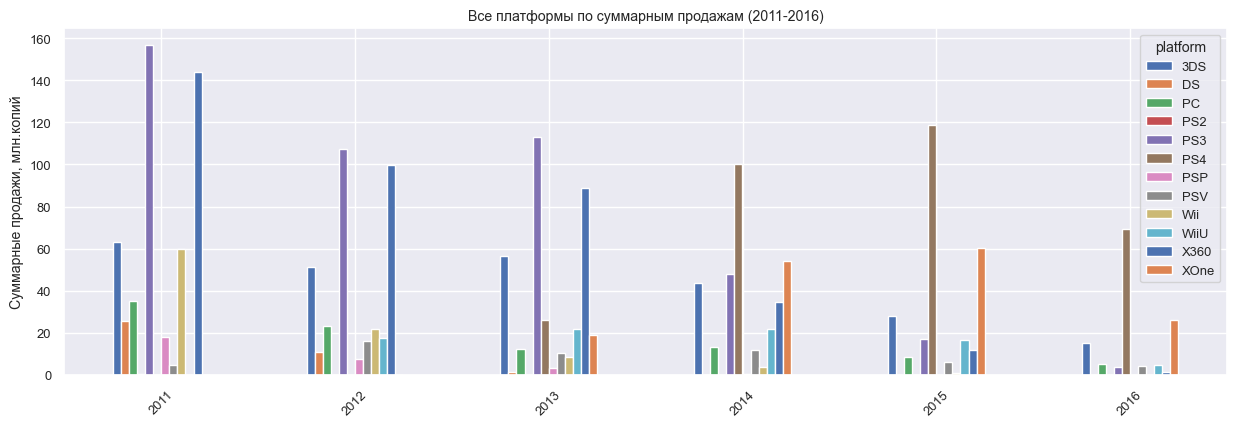

In [27]:
(data.query('year_of_release >= 2011')
     .pivot_table(index='year_of_release', columns='platform', values='sales_all', aggfunc='sum')
     .plot.bar(rot=45, 
               xlabel='', 
               ylabel='Суммарные продажи, млн.копий', 
               title='Все платформы по суммарным продажам (2011-2016)',
               legend=True,
               figsize=(15,4.5))
)
plt.show()

Поскольку задача состоит в прогнозировании на 2017 год, нас интересуют наиболее свежие данные по продажам.

Видно, что PS4 и XOne к 2015 уже смогли перенять на себя всю аудиторию старых платформ. В 2011 лидировали PS3 и X360, но в 2017 они уже не будут представлять интереса. Для целей прогнозирования продаж на следующий год, ввиду соображений актуальности данных для прогноза, возьмем более короткий период в три года. Так мы не захватим уже отжившие тренды, которые зависят не только от выхода новой игровой платформы. Отберем топ-5 платформ по продажам.

In [28]:
most_sales_platform = data.query('year_of_release >= 2014') \
                          .pivot_table(index='platform', values='sales_all', aggfunc='sum') \
                          .sort_values(by='sales_all', ascending=False).head(5).index

In [29]:
most_sales_platform

Index(['PS4', 'XOne', '3DS', 'PS3', 'X360'], dtype='object', name='platform')

In [30]:
data_fresh = data.query('(year_of_release >= 2014) & platform in @most_sales_platform').copy()

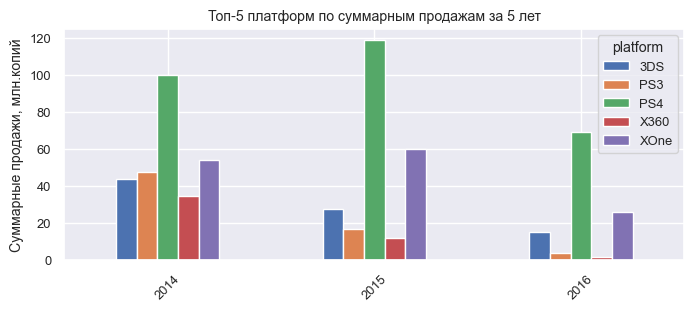

In [31]:
(data_fresh.pivot_table(index='year_of_release', columns='platform', values='sales_all', aggfunc='sum')
           .plot.bar(rot=45, 
                     xlabel='', 
                     ylabel='Суммарные продажи, млн.копий', 
                     title='Топ-5 платформ по суммарным продажам за 5 лет',
                     grid=True,
                     figsize=(8,3))
);

## Анализ глобальных продаж по популярным платформам

**Построим график "ящик с усами" по глобальным продажам игр в разбивке по платформам:**

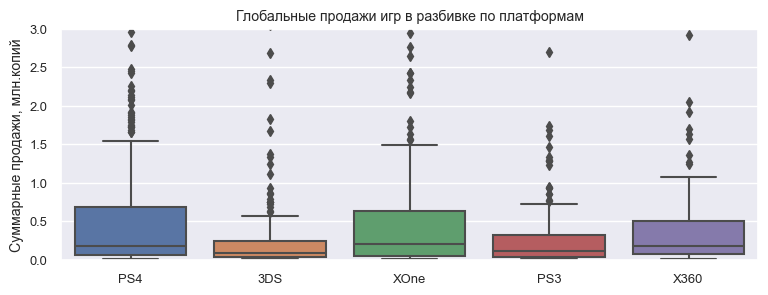

In [32]:
sns.set(rc={"figure.figsize":(9, 3)})
sns.set(font_scale=0.85)
ax = sns.boxplot(x=data_fresh['platform'], 
                 y=data_fresh['sales_all'])

ax.set_title('Глобальные продажи игр в разбивке по платформам')
ax.set(ylabel='Суммарные продажи, млн.копий', xlabel='')
ax.set_ylim(0,3);

In [33]:
data_fresh.groupby('platform')['sales_all'].describe()

,count,mean,std,min,25%,50%,75%,max
platform,,,,,,,,
3DS,212.0,0.408868,1.188368,0.01,0.0300,0.090,0.2500,11.68
PS3,219.0,0.311324,0.633059,0.01,0.0400,0.110,0.3250,5.27
PS4,376.0,0.766356,1.614969,0.01,0.0575,0.185,0.6900,14.63
X360,111.0,0.434414,0.628967,0.01,0.0700,0.180,0.5050,4.28
XOne,228.0,0.615614,1.046513,0.01,0.0500,0.205,0.6325,7.39


На графиках и таблице видим, что медиана PS3 и PS4 равны, и у XOne примерно такое же значение. Получается, 50% игр, продающихся на PS3, PS4 расходятся тиражом в более чем 180 тыс.копий, а другая половина в менее чем 180 тыс. копий. И только 25% игр PS4 и XOne продаются в >600-700 тыс. копий. Это та малая доля наиболее популярных игр с несколькими миллионами продаж.

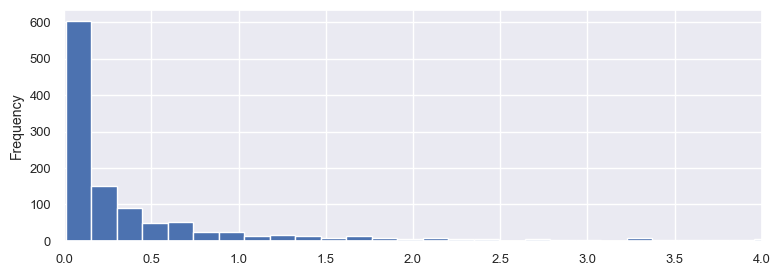

In [34]:
data_fresh['sales_all'].plot(kind='hist', xlim=(0,4), bins=100, xlabel='sales_all', ylabel='');

Это же видно на гистограмме суммарных продаж за все годы, большинство игр имеют меньше 200 тыс.копий.

## Влияние на продажи отзывов пользователей и критиков

**Нужно посмотреть, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков, затем соотнести выводы с продажами на других платформах. Возьмем самую популярную платформу на 2016 год — PS4.**

Зависимость по продажам от отзывов пользователей:

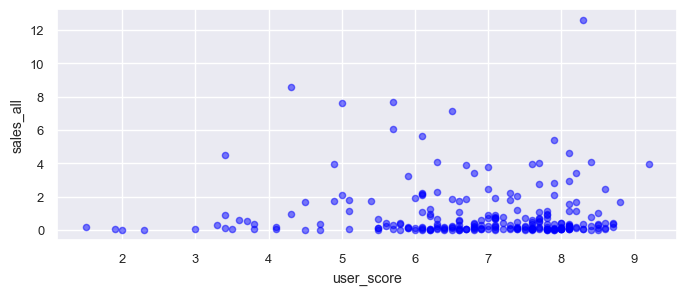

In [35]:
data_fresh.query('platform == "PS4"').plot(kind='scatter', x='user_score', y='sales_all', alpha=0.5, color='blue', figsize=(8,3));

In [36]:
print(data_fresh.query('platform == "PS4"')['sales_all'].corr(data_fresh.query('platform == "PS4"')['user_score']))

-0.04013158947269735


Корреляция равна нулю, и на графике видно, что оценки в районе 5.5-9 баллов распределены равномерно, вне зависимости от количества продаж (за исключением некоторых выбросов).

Зависимость по продажам от отзывов критиков:

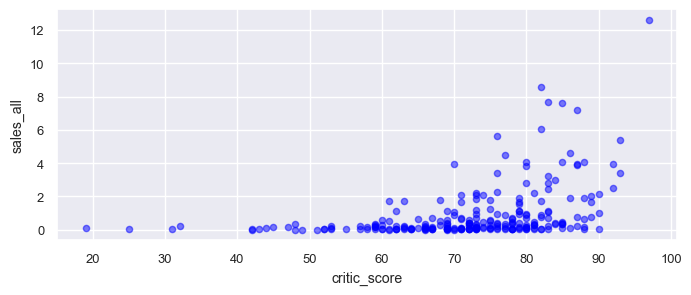

In [37]:
data_fresh.query('platform == "PS4"').plot(kind='scatter', x='critic_score', y='sales_all', alpha=0.5, color='blue', figsize=(8,3));

In [38]:
print(data_fresh.query('platform == "PS4"')['sales_all'].corr(data_fresh.query('platform == "PS4"')['critic_score']))

0.40266141068104083


<a id='conclusion'></a>
В случае с критиками корреляция равна 0.40 — связь есть, но она слишком слабая. Наблюдаемая корреляция обусловлена чуть более сконцентрированным облаком точек вокруг игр с несколькими миллионами копий, такие игры рассматривают чаще — это продукты с высоким бюджетом. Ввиду этого их оценка может быть выше.

**Соотнесем выводы с продажами игр на других платформах:**

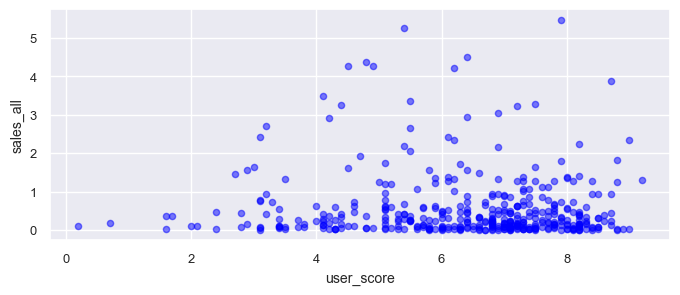

In [39]:
data_fresh.query('platform != "PS4"').plot(kind='scatter', x='user_score', y='sales_all', alpha=0.5, color='blue', figsize=(8,3));

In [40]:
print(data_fresh.query('platform != "PS4"')['sales_all'].corr(data_fresh.query('platform != "PS4"')['user_score']))

-0.05285553045768628


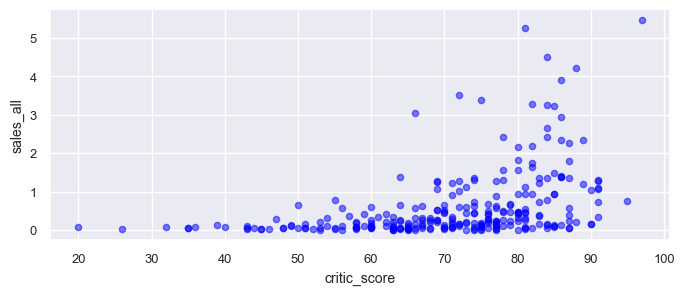

In [41]:
data_fresh.query('platform != "PS4"').plot(kind='scatter', x='critic_score', y='sales_all', alpha=0.5, color='blue', figsize=(8,3));

In [42]:
print(data_fresh.query('platform != "PS4"')['sales_all'].corr(data_fresh.query('platform != "PS4"')['critic_score']))

0.4154241251014942


В целом картина такая же — отзывы пользователей на продажи совсем не влияют, а отзывы критиков имеют слабую линейную связь. Предположительная причина такой связи была описана [выше](#conclusion).

## Общее распределение игр по жанрам

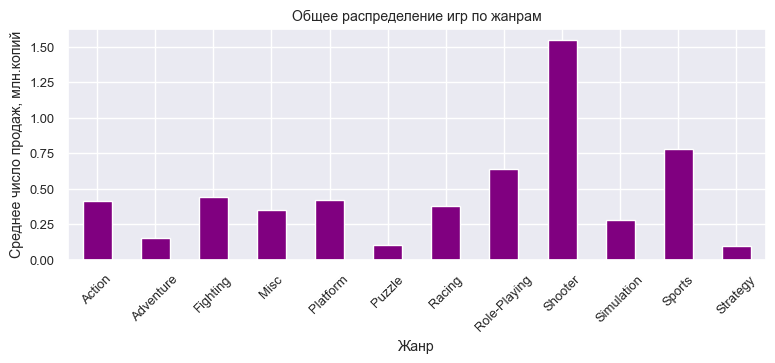

In [43]:
(data_fresh.pivot_table(index='genre', values='sales_all', aggfunc='mean')
           .plot(kind='bar', 
                 color='purple', 
                 rot=45,
                 xlabel='Жанр',
                 ylabel='Среднее число продаж, млн.копий',
                 title='Общее распределение игр по жанрам',
                 legend=False)
);

Наиболее продаваемые жанры — шутеры, спорт и ролевые с игрой за персонажа. Самые низкие продажи у стратегий и пазлов.

## Составление портрета пользователя каждого региона

Определим для пользователей каждого региона (EU, NA, JP) самые популярные платформы, жанры и влияние рейтинга ESRB на продажи.

### Топ-5 платформ в регионах

Составим функцию, строящую графики для каждого случая.

In [44]:
def top5(data_fresh, argument, region, title, color='lightblue'):
    df = data_fresh.pivot_table(index=argument, values=region, aggfunc='sum')
    df.columns = ['percent'] #тут хранится сумма, потом пересчитаем в проценты
    df['percent'] = df['percent'] / sum(df['percent']) * 100
    (df.plot(kind='bar', 
             color=color, 
             rot=40,
             xlabel='',
             ylabel='Число продаж, %',
             title=title,
             figsize=(8,2.5),
             legend=False)
    );
    return None

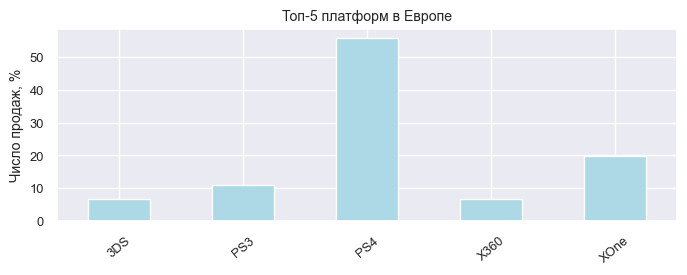

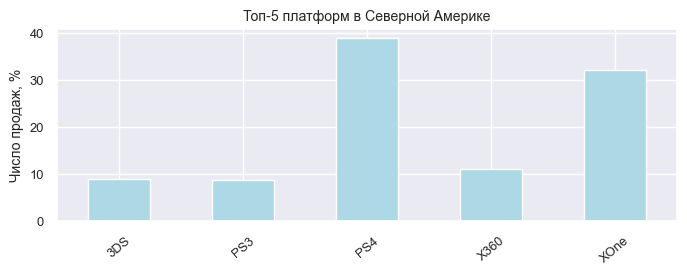

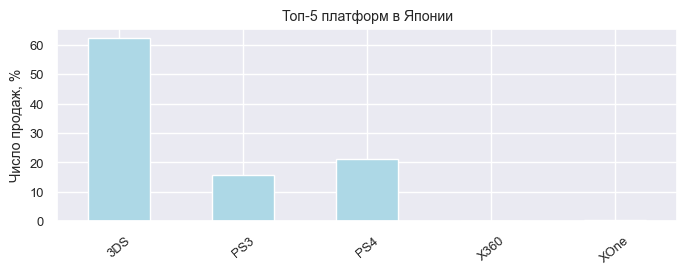

In [45]:
top5(data_fresh, 'platform', 'eu_sales', 'Топ-5 платформ в Европе')
top5(data_fresh, 'platform', 'na_sales', 'Топ-5 платформ в Северной Америке')
top5(data_fresh, 'platform', 'jp_sales', 'Топ-5 платформ в Японии')

Поскольку PlayStation в целом популярнее, чем Xbox от Microsoft, мы видим ее ожидаемую наибольшую популярность в Европе.<br>

В Северной Америке ситуация такая же, здесь PS4 лидирует, но консоли Xbox One уже популярнее и отстают менее чем на 10%, разумно связать эту разницу с принадлежностью бренда Xbox от Microsoft к данному региону.<br>

В Японии самая популярная платформа Nintendo 3DS. Ее особенность в том, что это не привычная нам стационарная консоль, а портативная. Видимо, японцам больше нравится играть в Pokemon, Zelda, Mario — наиболее характерные игры этой платформы. Еще мы видим, что вместо Xbox в Японии предпочитают PS от их же бренда Sony.

### Топ-5 жанров в регионах

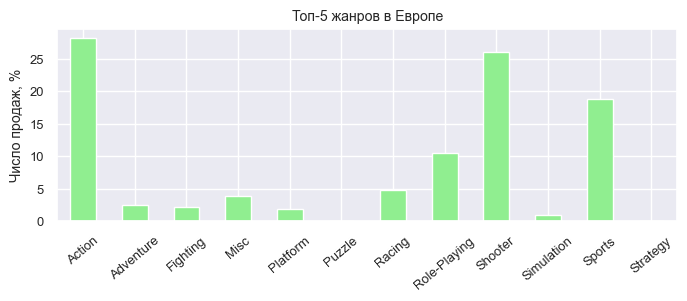

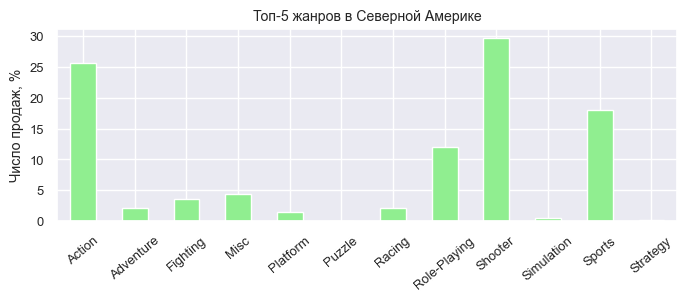

In [46]:
top5(data_fresh, 'genre', 'eu_sales', 'Топ-5 жанров в Европе', color='lightgreen')
top5(data_fresh, 'genre', 'na_sales', 'Топ-5 жанров в Северной Америке', color='lightgreen')

Можно резюмировать, что топ-5 популярных жанров в Европе и Северной Америке практически идентичен. На первых местах шутеры, аркады, спорт, ролевые игры. На последнем месте в Европе гонки (Racing), а в Северной Америке аркады (Misc). Схожесть интересов может быть связана со схожими культурными особенностями западных регионов.

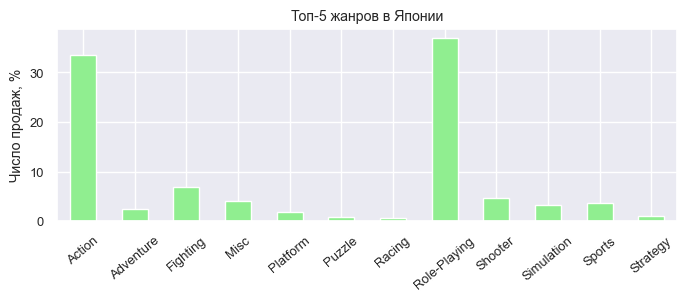

In [47]:
top5(data_fresh, 'genre', 'jp_sales', 'Топ-5 жанров в Японии', color='lightgreen')

В Японии на первом месте, наоборот, ролевые игры — 37% всех продаж, аркады здесь также популярны и составляют около 33% продаж. Остальные жанры не особо распространены и распределены равномерно. Такое значительное отличие аналогично можно связать с разным культурным бэкграундом запада и востока.

### Влияние рейтинга ESRB на продажи в отдельных регионах

Для построения графиков продолжим пользоваться функцией top5, поскольку структурно суть задачи не изменилась.

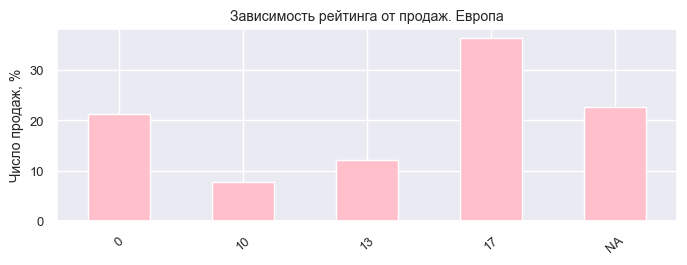

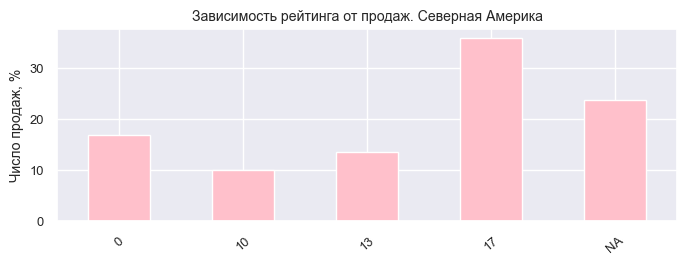

In [48]:
top5(data_fresh, 'rating', 'eu_sales', 'Зависимость рейтинга от продаж. Европа', color='pink')
top5(data_fresh, 'rating', 'na_sales', 'Зависимость рейтинга от продаж. Северная Америка', color='pink')

В Европе и Северной Америке в среднем одинаковые предпочтения с точки зрения возрастного рейтинга игр. Лучше всего продаются игры для взрослых 17+. На втором месте игры без указанного возрастного ценза (NA), их доля составляет около 23%. Игры 0+ в Европе несколько популярнее, их доля на 5 процентов больше. 

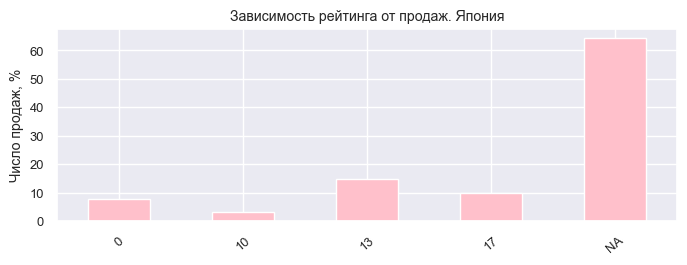

In [49]:
top5(data_fresh, 'rating', 'jp_sales', 'Зависимость рейтинга от продаж. Япония', color='pink')

В Японии подавляющее большинство занимают игры без рейтинга (NA), далее идут игры для подростков T(13+) и для взрослых M(17+) —  их доля около 10%.

**Рейтинг ESRB влияет на продажи в отдельных регионах. Новая игра с рейтингом M(17+) вероятнее будет иметь популярность в Европе и Северной Америке, а без рейтинга — в Японии.**

## Проверка гипотез

### Гипотеза о равенстве средних пользовательских рейтингов платформ Xbox One и PC

Можем рассматривать задачу как проверку гипотезы о равенстве средних двух генеральных совокупностей. Сформулируем нулевую и альтернативную гипотезы:
```
H_0: Рейтинг пользователей XOne = Рейтинг пользователей PC
H_a: Рейтинг пользователей XOne ≠ Рейтинг пользователей PC
alpha = 0.05
```
**Проведем t-test**

In [50]:
from scipy import stats as st

In [51]:
xone = data.query('platform == "XOne"')['user_score'].dropna() #без удаления пропущенных значений тест не сработает
pc = data.query('platform == "PC"')['user_score'].dropna()

#Проверка гипотезы по двум выборкам. Можно рассчитать среднее по одной и сравнить с выборкой, проведя двусторонний тест
#Но лучше рассматривать задачу как равенство средних двух ген. совокупностей
results = st.ttest_ind(xone, pc, equal_var=False) #совокупности хоть и большие, но разного размера, принимаем дисперсию разной
alpha = 0.05 #классическое значение в 5%

#p_value
print(f'p_value = {results.pvalue:2f}')

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу \n') #Значит рейтинг пользователей XOne ≠ Рейтинг пользователей PC
    print('Средний рейтинг пользователей XOne ≠ Средний рейтинг пользователей PC')
    print(f'Средний рейтинг XOne = {xone.mean():.2f}')
    print(f'Средний рейтинг PC = {pc.mean():.2f}')
else:
    print('Не получилось отвергнуть нулевую гипотезу \n')
    print('Средний рейтинг пользователей XOne = Средний рейтинг пользователей PC')
    print(f'Средний рейтинг XOne = {xone.mean():.2f}')
    print(f'Средний рейтинг PC = {pc.mean():.2f}')

p_value = 0.000005
Отвергаем нулевую гипотезу 

Средний рейтинг пользователей XOne ≠ Средний рейтинг пользователей PC
Средний рейтинг XOne = 6.52
Средний рейтинг PC = 7.06


*Выходит, что при условии истинности нулевой гипотезы, вероятность получить такой же или более далекий результат, как у XOne, равна 0 процентов. Разница в средних оценках была бы статистически значима даже при alpha=0.001.*

Если проводить двусторонний тест 1samp и сравнивать среднее значение выборки с другим предварительно рассчитанным, p_value будет еще ниже. Принципиальной разницы в результатах нет.

### Проверка гипотезы о различии средних пользовательских рейтингов жанров Action и Sports

```
H_0: Средний рейтинг жанра Action = Средний рейтинг жанра Sports 
H_a: Средний рейтинг жанра Action ≠ Средний рейтинг жанра Sports
alpha = 0.05
```

In [52]:
action = data.query('genre == "Action"')['user_score'].dropna() #без удаления пропущенных значений тест не сработает
sports = data.query('genre == "Sports"')['user_score'].dropna()

results = st.ttest_ind(action, sports, equal_var=False) #принимаем дисперсию разной, т.к. размер выборок различен
alpha = 0.05 #классическое значение в 5%

#p_value
print(f'p_value = {results.pvalue:2f}')

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу \n') #Значит средний рейтинг жанра Action ≠ средний рейтинг жанра Sports
    print('Средний рейтинг жанра Action ≠ Средний рейтинг жанра Sports')
    print(f'Средний рейтинг Action = {action.mean():.2f}')
    print(f'Средний рейтинг Sports = {sports.mean():.2f}')
else:
    print('Не получилось отвергнуть нулевую гипотезу \n')
    print('Средний рейтинг жанра Action = Средний рейтинг жанра Sports')
    print(f'Средний рейтинг Action = {action.mean():.2f}')
    print(f'Средний рейтинг Sports = {sports.mean():.2f}')

p_value = 0.076073
Не получилось отвергнуть нулевую гипотезу 

Средний рейтинг жанра Action = Средний рейтинг жанра Sports
Средний рейтинг Action = 7.06
Средний рейтинг Sports = 6.95


*Как видно, средний рейтинг этих жанров практически равен, а вероятноть получить такое же или более далекое значение равна 7%. Эта разница статистически незначима, поэтому нулевая гипотеза и не была отвергнута.*

# Общий вывод

В рамках исследования требовалось выявить определяющие успешность игры закономерности, чтобы в дальнейшем сделать ставку на потенциально популярный продукт и спланировать рекламные кампании на 2017 год.

1. Были рассмотрены распределение количества выпускаемых игр в разные годы и динамика изменения продаж по платформам. Мы отобрали платформы с наибольшими суммарными продажами и определили, за какой характерный срок появляются новые и исчезают старые. Выяснилось, что игровая консоль является актуальной в среднем 6-8 лет.
2. PS4 и XOne к 2015 уже смогли перенять на себя всю аудиторию старых платформ. *В рамках рекламной кампании рентабельно сделать упор на играх, выпускаемых под эти консоли.* В 2011 лидировали PS3 и X360, но в 2017 они уже не будут представлять интереса. Поэтому, ввиду соображений о будущем прогнозировании, было решено принять актуальным период в 3 года. 
3. В пределах актуального периода были отобраны топ-5 потенциально прибыльных платформ: PS4, PS3, X360, 3DS, XOne. По графикам обнаружено, что медиана PS3 и PS4 равны, и у XOne примерно такое же значение. Получается, 50% игр, продающихся на PS3, PS4 расходятся тиражом в более чем 180 тыс.копий, а другая половина в менее чем 180 тыс. копий. И только 25% игр PS4 и XOne продаются в >600-700 тыс. копий. Это та малая доля наиболее популярных игр с несколькими миллионами продаж.
4. Влияние отзывов пользователей на продажи игр не выявлено. Средняя оценка критиков, наоборот, коррелируют с продажами в районе 0,4. Достаточно слабая зависимость, обусловленная естественным успехом популярных и высокобюджетных игр, которые они оценивают.
5. Было рассмотрено общее распределение игр по жанрам. Наиболее продаваемые жанры — шутеры, спорт и ролевые с игрой за персонажа. Самые низкие продажи у стратегий и пазлов.

**Портреты пользователей каждого региона**<br>
Определили для пользователей каждого региона (EU, NA, JP) самые популярные платформы, жанры и влияние рейтинга ESRB на продажи:

**Популярные платформы**<br>
Поскольку PlayStation в целом популярнее, чем Xbox от Microsoft, мы видим ее ожидаемую наибольшую популярность в Европе — доля всех проданных игр на PS4 — 55%, Xbox One — 20%. <br>
В Северной Америке ситуация такая же, здесь PS4 лидирует (38%), но консоли Xbox One уже популярнее и лишь немного отстают (33%), разумно связать эту разницу с принадлежностью бренда Xbox от Microsoft к данному региону.<br>
В Японии самая популярная платформа Nintendo 3DS (62%). Ее особенность в том, что это не привычная стационарная консоль, а портативная. Видимо, японцам больше нравится играть в Pokemon, Zelda, Mario — наиболее характерные игры этой платформы. Еще мы видим, что вместо Xbox в Японии предпочитают PS от их же бренда Sony (PS3 — 15%, PS4 — 20%).<br>

**Популярные жанры**<br>
Топ-5 популярных жанров в Европе и Северной Америке практически идентичен. На первых местах шутеры, аркады, спорт, ролевые игры. На последнем месте в Европе гонки (Racing), а в Северной Америке аркады (Misc). Схожесть интересов может быть связана со схожими культурными особенностями западных регионов. <br>
В Японии на первом месте, наоборот, ролевые игры — 37% всех продаж, аркады здесь также популярны и составляют около 33% продаж. Остальные жанры не особо распространены и распределены равномерно. Такое значительное отличие аналогично можно связать с разным культурным бэкграундом запада и востока. <br>

**Влияние рейтинга ESRB на продажи в отдельном регионе**<br>
В Европе и Северной Америке в среднем одинаковые предпочтения с точки зрения возрастного рейтинга игр. Лучше всего продаются игры для взрослых 17+ (32%). На втором месте игры без указанного возрастного ценза (NA), их доля составляет около 23%. Игры 0+ в Европе несколько популярнее, их доля на 5 процентов больше (22%).<br>
В Японии подавляющее большинство занимают игры без рейтинга (NA) — 60%, далее идут игры для подростков T(13+) и для взрослых M(17+) —  их доля около 10%.<br>

*Рейтинг ESRB влияет на продажи только в отдельных регионах. Новая игра с рейтингом M(17+) вероятнее будет иметь популярность в Европе и Северной Америке. В Японии любят игры без рейтинга, они составляют более 60% продаж.*
<br>

**С помощью статистических тестов были проверены гипотезы о равенстве средних пользовательских рейтингов по жанрам игр и по платформам, на которые они были выпущены.**

1. Гипотеза о равенстве средних пользовательских рейтингов платформ Xbox One и PC **была отвергнута** с уровнем статистической значимости в 5% (p_value = 0.000005). <br> 
*Таким образом, средний рейтинг пользователей Xbox One (6.52) ≠ cредний рейтинг пользователей PC (7.06).* <br>

2. Гипотеза о равенстве средних пользовательских рейтингов жанров Action и Sports **не была отвергнута** с уровнем статистической значимости в 5% (p_value = 0.07). <br>
*Средний рейтинг жанра Action (7.06) = средний рейтинг жанра Sports (6.95)* <br>